In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\Vishwam\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Vishwam\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
df=pd.read_csv(".\hourly-energy-consumption\PJME_hourly.csv", index_col=[0], parse_dates=[0])

## Descriptive Analysis

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


#### Description of Data

In [5]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


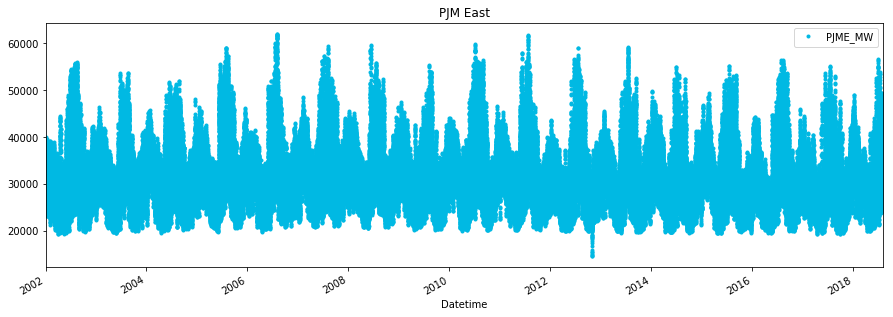

In [6]:
color_pal = ["darkblue","#00B9E3"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[1], title='PJM East')

## Train/Test Split 

In [10]:
PJME_train, PJME_test= np.split(df, [int(.60 *len(df))]) 

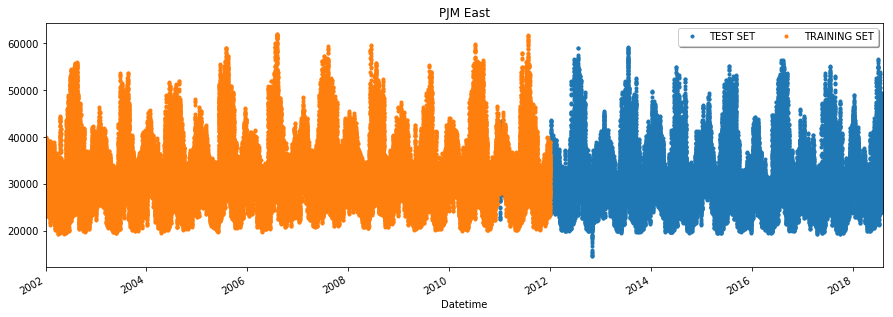

In [11]:
 _= PJME_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(PJME_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')\
    .legend(loc='upper right',shadow=True, ncol=2)

In [12]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [13]:
X_train, y_train = create_features(PJME_train, label='PJME_MW')
X_test, y_test = create_features(PJME_test, label='PJME_MW')

In [14]:
reg = xgb.XGBRegressor(n_estimators=1000,booster='gbtree')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:23335.78906	validation_1-rmse:22273.00586
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:16514.01758	validation_1-rmse:15438.52832
[2]	validation_0-rmse:11790.96484	validation_1-rmse:10767.06934
[3]	validation_0-rmse:8560.11426	validation_1-rmse:7645.46436
[4]	validation_0-rmse:6387.15674	validation_1-rmse:5631.03272
[5]	validation_0-rmse:4962.77344	validation_1-rmse:4444.29443
[6]	validation_0-rmse:4067.99097	validation_1-rmse:3827.67554
[7]	validation_0-rmse:3517.23413	validation_1-rmse:3586.59888
[8]	validation_0-rmse:3203.50781	validation_1-rmse:3511.44019
[9]	validation_0-rmse:3006.81470	validation_1-rmse:3505.00952
[10]	validation_0-rmse:2851.01318	validation_1-rmse:3559.59009
[11]	validation_0-rmse:2792.65356	validation_1-rmse:3589.19238
[12]	validation_0-rmse:2692.58887	validation_1-rmse:3620.11816
[13]	validation_0-rmse:265

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

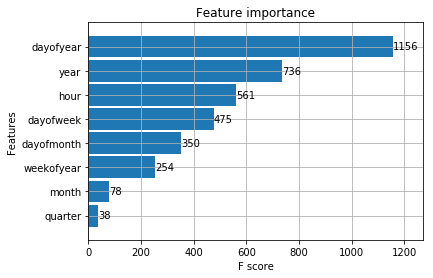

In [15]:
_ = plot_importance(reg, height=0.9)

## Forcast on Test Set 

In [16]:
PJME_test['MW_Prediction'] = reg.predict(X_test)
PJME_all = pd.concat([PJME_test, PJME_train], sort=False)

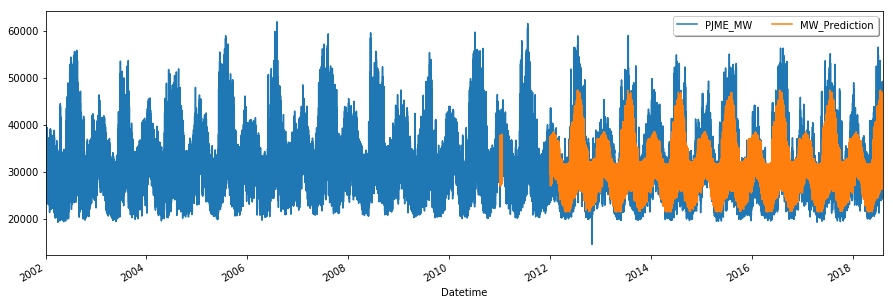

In [17]:
_ = PJME_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5)).legend(loc='upper right',shadow=True, ncol=2)

### First month of Prediction 

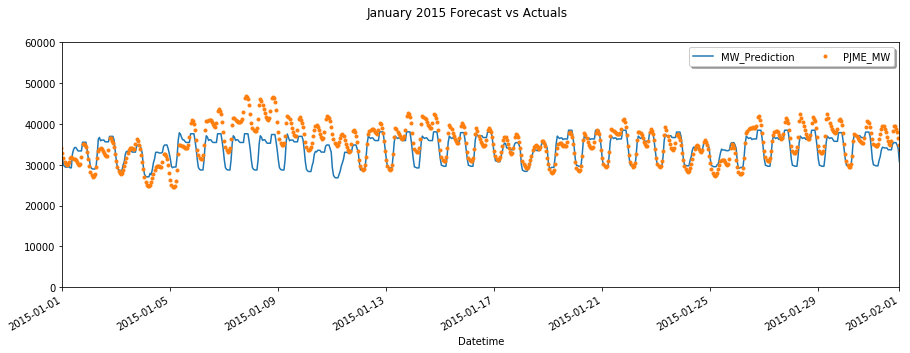

In [18]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = PJME_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
ax.legend(loc='upper right',shadow=True, ncol=2)

### Prediction for First Week of July

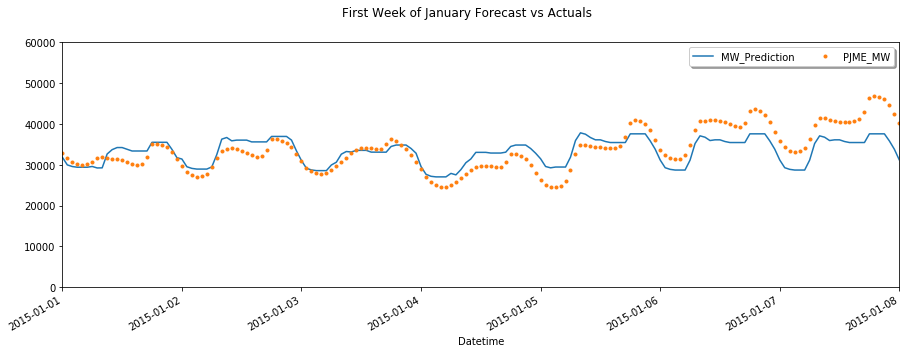

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = PJME_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')
ax.legend(loc='upper right',shadow=True, ncol=2)

## Error Metrics On Test Set 

### Mean Squared Error 

In [20]:
mean_squared_error(y_true=PJME_test['PJME_MW'],
                   y_pred=PJME_test['MW_Prediction'])

12285097.022496179

### Mean Absolute Error 

In [21]:
mean_absolute_error(y_true=PJME_test['PJME_MW'],
                   y_pred=PJME_test['MW_Prediction'])

2678.3842588611624

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Mean Absolute Error Percentage

In [23]:
mean_absolute_percentage_error(y_true=PJME_test['PJME_MW'],
                   y_pred=PJME_test['MW_Prediction'])

8.402365451385966

In [24]:
PJME_test['error'] = PJME_test['PJME_MW'] - PJME_test['MW_Prediction']
PJME_test['abs_error'] = PJME_test['error'].apply(np.abs)
error_by_day = PJME_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

## Looking at Best and Worst Days Predicted

#### Worst Days Predicted  

In [25]:
error_by_day.sort_values('error', ascending=True).head(10)

,,,PJME_MW,MW_Prediction,error,abs_error
year,month,dayofmonth,,,,
2012,10,30,19769.041667,29074.318359,-9305.277507,9305.277507
2016,7,4,28399.958333,36799.839844,-8399.882487,8399.882487
2013,8,15,30004.791667,38003.691406,-7998.900879,7998.900879
2014,7,29,31024.375000,38947.410156,-7923.034993,7923.034993
2013,5,27,23873.875000,31685.103516,-7811.228271,7811.228271
2017,8,7,30521.166667,38221.445312,-7700.276855,7700.276855
2013,8,5,31229.458333,38891.824219,-7662.364583,7662.364583
2016,6,9,27318.083333,34722.605469,-7404.522786,7404.522786
2018,6,11,27287.958333,34686.289062,-7398.329834,7398.329834


#### Best Days Predicted

In [26]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2014 10    16          28638.000000   28905.488281 -267.487712  404.040771
2012 5     21          29403.333333   29107.947266  295.385579  410.978678
           14          29023.416667   28822.822266  200.594238  414.415365
2016 11    29          29259.333333   29269.902344  -10.569661  425.278646
     10    27          28611.166667   28714.236328 -103.070231  431.285889
2015 5     6           28948.666667   28876.117188   72.548665  451.839030
2017 10    24          28657.416667   28962.480469 -305.063232  467.432373
     2     3           34424.375000   34314.152344  110.221517  474.000651
2016 2     17          33311.791667   33512.105469 -200.312419  478.989176
2012 5     9           28763.833333   28876.117188 -112.284668  491.756022

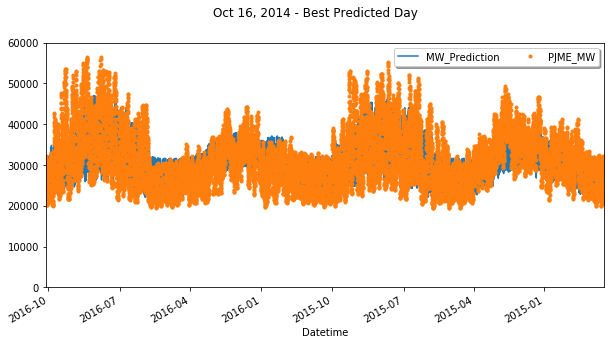

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = PJME_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-16-2014', upper='10-04-2016')
plot = plt.suptitle('Oct 16, 2014 - Best Predicted Day')
ax.legend(loc='upper right',shadow=True, ncol=2)